In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, Flatten
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [ ]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Potencia generada')
    plt.plot(predicted, color='blue',label='Predicción')
    plt.title('Predicción LSTM')
    plt.xlabel('Time')
    plt.ylabel('Salida')
    plt.legend()
    plt.show()

In [ ]:
df_Plant1_Generation = pd.read_csv("Plant_1_Generation_Data.csv", sep = ",",low_memory = False , encoding = 'utf_8')
df_Plant1_Weather = pd.read_csv("Plant_1_Weather_Sensor_Data.csv", sep = ",",low_memory = False , encoding = 'utf_8')

In [ ]:
df_Plant1_Generation

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.000,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.000,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.000,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.000,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.000,7158964.0
...,...,...,...,...,...,...,...
68773,17-06-2020 23:45,4135001,uHbuxQJl8lW7ozc,0.0,0.0,5967.000,7287002.0
68774,17-06-2020 23:45,4135001,wCURE6d3bPkepu2,0.0,0.0,5147.625,7028601.0
68775,17-06-2020 23:45,4135001,z9Y9gH1T5YWrNuG,0.0,0.0,5819.000,7251204.0
68776,17-06-2020 23:45,4135001,zBIq5rxdHJRwDNY,0.0,0.0,5817.000,6583369.0


In [ ]:
df_Plant1_Generation.drop(['SOURCE_KEY','PLANT_ID'],axis = 1 , inplace = True)
df_Plant1_Weather.drop(['SOURCE_KEY','PLANT_ID'],axis = 1 , inplace = True)

In [ ]:
#Formato de fecha
df_Plant1_Generation['DATE_TIME']= pd.to_datetime(df_Plant1_Generation['DATE_TIME'])
df_Plant1_Weather['DATE_TIME']= pd.to_datetime(df_Plant1_Weather['DATE_TIME'])

In [ ]:
plant1 = pd.merge(df_Plant1_Generation, df_Plant1_Weather, how='inner', on = 'DATE_TIME')

In [ ]:
plant1.head()

,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15,0.0,0.0,0.0,6259559.0,25.184316,22.857507,0.0
1,2020-05-15,0.0,0.0,0.0,6183645.0,25.184316,22.857507,0.0
2,2020-05-15,0.0,0.0,0.0,6987759.0,25.184316,22.857507,0.0
3,2020-05-15,0.0,0.0,0.0,7602960.0,25.184316,22.857507,0.0
4,2020-05-15,0.0,0.0,0.0,7158964.0,25.184316,22.857507,0.0


In [ ]:
plant1.shape

(45680, 8)

In [ ]:
features = plant1[['AC_POWER','DAILY_YIELD','TOTAL_YIELD','AMBIENT_TEMPERATURE','IRRADIATION']].copy()

In [ ]:
features.index = plant1['DATE_TIME']

In [ ]:
features

,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,
2020-05-15 00:00:00,0.0,0.000,6259559.0,25.184316,0.0
2020-05-15 00:00:00,0.0,0.000,6183645.0,25.184316,0.0
2020-05-15 00:00:00,0.0,0.000,6987759.0,25.184316,0.0
2020-05-15 00:00:00,0.0,0.000,7602960.0,25.184316,0.0
2020-05-15 00:00:00,0.0,0.000,7158964.0,25.184316,0.0
...,...,...,...,...,...
2020-06-17 23:45:00,0.0,5967.000,7287002.0,21.909288,0.0
2020-06-17 23:45:00,0.0,5147.625,7028601.0,21.909288,0.0
2020-06-17 23:45:00,0.0,5819.000,7251204.0,21.909288,0.0


In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45680 entries, 2020-05-15 00:00:00 to 2020-06-17 23:45:00
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AC_POWER             45680 non-null  float64
 1   DAILY_YIELD          45680 non-null  float64
 2   TOTAL_YIELD          45680 non-null  float64
 3   AMBIENT_TEMPERATURE  45680 non-null  float64
 4   IRRADIATION          45680 non-null  float64
dtypes: float64(5)
memory usage: 2.1 MB


In [ ]:
training_set = features[:'2020-06-12'].iloc[:,0:5]
test_set = features['2020-06-13':].iloc[:,0:5]

In [ ]:
training_set.shape

(35164, 5)

In [ ]:
test_set.shape

(10516, 5)

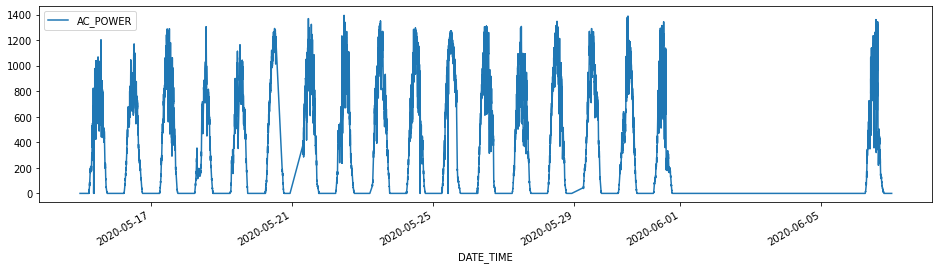

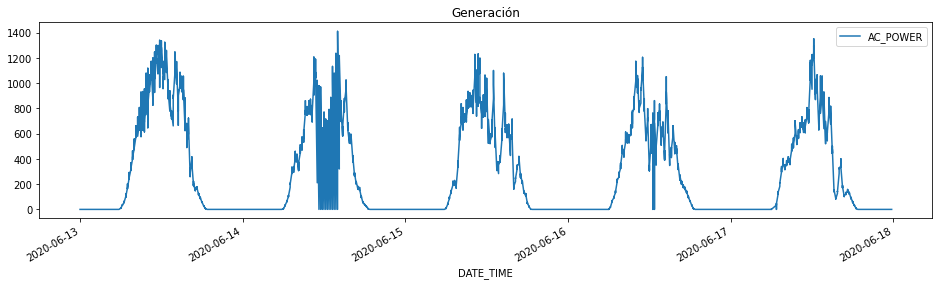

In [ ]:
features['AC_POWER'][:'2020-06-12'].plot(figsize=(16,4),legend=True)
features[['AC_POWER']]['2020-06-13':].plot(figsize=(16,4),legend=True)
plt.title('Generación')
plt.show()

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(training_set)
training_set_scaled = scaler.transform(training_set)

In [ ]:
X_train = []
y_train = []
n_future = 1 #vector
n_past = 60
for i in range(n_past,len(training_set_scaled)):

  X_train.append(training_set_scaled[i-n_past:i,0:training_set_scaled.shape[1]])
  y_train.append(training_set_scaled[i+n_future-1:i + n_future,0])

X_train, y_train = np.array(X_train),np.array(y_train)
print(X_train.shape)
print(y_train.shape)

(35104, 60, 5)
(35104, 1)


##**GRU**

In [ ]:
#Arquitectura GRU
regressorGRU = Sequential()

regressorGRU.add(GRU(64, return_sequences=True,input_shape=(X_train.shape[1],5)))
regressorGRU.add(Dropout(0.2)) #Se agregaron dropout luego de primera ejecuc
regressorGRU.add(GRU(64, return_sequences=True))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(64, return_sequences=True))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(64))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(Dense(1))

In [ ]:
regressorGRU.compile(optimizer=SGD(learning_rate=0.01,momentum=0.9),loss='mean_squared_error')
regressorGRU.fit(X_train,y_train,epochs=20,batch_size=32)

Epoch 1/20
1097/1097 [==============================] - 80s 64ms/step - loss: 0.0411
Epoch 2/20
1097/1097 [==============================] - 70s 64ms/step - loss: 0.0294
Epoch 3/20
1097/1097 [==============================] - 70s 64ms/step - loss: 0.0272
Epoch 4/20
1097/1097 [==============================] - 70s 64ms/step - loss: 0.0265
Epoch 5/20
1097/1097 [==============================] - 71s 64ms/step - loss: 0.0253
Epoch 6/20
1097/1097 [==============================] - 70s 63ms/step - loss: 0.0248
Epoch 7/20
1097/1097 [==============================] - 69s 63ms/step - loss: 0.0243
Epoch 8/20
1097/1097 [==============================] - 69s 63ms/step - loss: 0.0239
Epoch 9/20
1097/1097 [==============================] - 69s 63ms/step - loss: 0.0236
Epoch 10/20
1097/1097 [==============================] - 69s 63ms/step - loss: 0.0231
Epoch 11/20
1097/1097 [==============================] - 69s 63ms/step - loss: 0.0229
Epoch 12/20
1097/1097 [==============================] - 69s 63

In [ ]:
dataset_total = pd.concat((features[['AC_POWER','DAILY_YIELD','TOTAL_YIELD','AMBIENT_TEMPERATURE','IRRADIATION']][:'2020-06-12'],
                           features[['AC_POWER','DAILY_YIELD','TOTAL_YIELD','AMBIENT_TEMPERATURE','IRRADIATION']]['2020-06-13':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
print(inputs.shape)

inputs = inputs.reshape(-1,5)
inputs  = scaler.transform(inputs)

(10576, 5)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
print(inputs.shape)

(10576, 5)


In [ ]:
X_test = []
for i in range(60,10576):
    X_test.append(inputs[i-60:i,0:5])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],5))
print(X_test.shape)
#predicted = regressorGRU.predict(X_test)
#predicted = predicted.reshape((predicted.shape[0],predicted.shape[1]))


(10516, 60, 5)


In [ ]:
predicted2 = predicted[:,0]

In [ ]:
predicted2.shape

(10516,)

In [ ]:
predicted2_copies_array = np.repeat(predicted2,5, axis=-1)

In [ ]:
predicted2_copies_array.shape

(52580,)

In [ ]:
conv_predicted = scaler.inverse_transform(np.reshape(predicted2_copies_array,(len(predicted2),5)))

In [ ]:
conv_predicted[:,0].shape

(10516,)

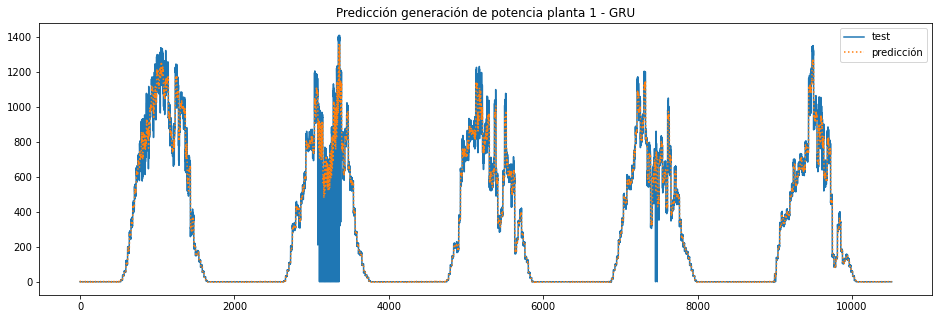

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(np.array(test_set)[:,0],label='test')
plt.plot(conv_predicted[:,0],label="predicción", linestyle = ':')
plt.legend(loc='best')
plt.title("Predicción generación de potencia planta 1 - GRU")
plt.show()

In [ ]:
test_set.shape

(10516, 5)

In [ ]:
predicted.shape

(251, 60, 1)

In [ ]:
inputs.shape

(10576, 5)

##**LSTM**

In [ ]:
#Arquitectura LSTM
regressorLSTM = Sequential()

regressorLSTM.add(LSTM(64, return_sequences=True,input_shape=(X_train.shape[1],5)))
regressorLSTM.add(Dropout(0.2)) #Se agregaron dropout luego de primera ejecuc
regressorLSTM.add(LSTM(64, return_sequences=True))
regressorLSTM.add(Dropout(0.2))
regressorLSTM.add(LSTM(64, return_sequences=True))
regressorLSTM.add(Dropout(0.2))
regressorLSTM.add(LSTM(64))
regressorLSTM.add(Dropout(0.2))
regressorLSTM.add(Dense(1))

In [ ]:
regressorLSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            17920     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 64)            33024     
                                                                 
 dropout_2 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                3

In [ ]:
regressorLSTM.compile(optimizer=SGD(learning_rate=0.01,momentum=0.9),loss='mean_squared_error')
regressorLSTM.fit(X_train,y_train,epochs=20,batch_size=32)

Epoch 1/20
1097/1097 [==============================] - 23s 13ms/step - loss: 0.0524
Epoch 2/20
1097/1097 [==============================] - 14s 12ms/step - loss: 0.0343
Epoch 3/20
1097/1097 [==============================] - 14s 13ms/step - loss: 0.0303
Epoch 4/20
1097/1097 [==============================] - 14s 12ms/step - loss: 0.0282
Epoch 5/20
1097/1097 [==============================] - 15s 13ms/step - loss: 0.0270
Epoch 6/20
1097/1097 [==============================] - 14s 13ms/step - loss: 0.0259
Epoch 7/20
1097/1097 [==============================] - 14s 12ms/step - loss: 0.0249
Epoch 8/20
1097/1097 [==============================] - 14s 13ms/step - loss: 0.0242
Epoch 9/20
1097/1097 [==============================] - 14s 13ms/step - loss: 0.0238
Epoch 10/20
1097/1097 [==============================] - 14s 13ms/step - loss: 0.0233
Epoch 11/20
1097/1097 [==============================] - 14s 12ms/step - loss: 0.0228
Epoch 12/20
1097/1097 [==============================] - 14s 12

In [ ]:
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [ ]:
predictedLSTM = regressorLSTM.predict(X_test)

In [ ]:
predicted2LSTM = predictedLSTM[:,0]

In [ ]:
predicted2LSTM_copies_array = np.repeat(predicted2LSTM,5, axis=-1)

In [ ]:
predicted2LSTM_copies_array.shape

(52580,)

In [ ]:
conv_predictedLSTM = scaler.inverse_transform(np.reshape(predicted2LSTM_copies_array,(len(predicted2LSTM),5)))

In [ ]:
conv_predictedLSTM.shape

(10516, 5)

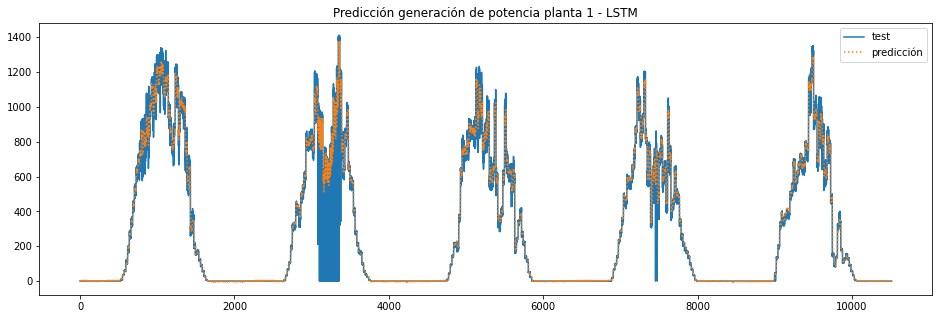

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(np.array(test_set)[:,0],label='test')
plt.plot(conv_predictedLSTM[:,0],label="predicción", linestyle = ':')
plt.legend(loc='best')
plt.title("Predicción generación de potencia planta 1 - LSTM")
plt.show()

In [ ]:
print(return_rmse(np.array(test_set)[:,0],conv_predictedLSTM[:,0]))

The root mean squared error is 62.522625871303134.
None


##**CONV**

In [ ]:
#Arquitectura convolucional
regressorCONV = Sequential()

regressorCONV.add(Conv1D(64, kernel_size=3,input_shape=(X_train.shape[1],5)))
regressorCONV.add(Dropout(0.2)) #Se agregaron dropout luego de primera ejecuc
regressorCONV.add(Conv1D(64, kernel_size=3,input_shape=(X_train.shape[1],5)))#se debe poner el mismo input shape en todas las capas
regressorCONV.add(Dropout(0.2))
regressorCONV.add(Conv1D(64, kernel_size=3,input_shape=(X_train.shape[1],5)))
regressorCONV.add(Dropout(0.2))
#regressorCONV.add(Conv1D(64,kernel_size=3,input_shape=(X_train.shape[1],5)))
#regressorCONV.add(Dropout(0.2))
regressorCONV.add(Flatten())
regressorCONV.add(Dense(1))

In [ ]:
regressorCONV.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 64)            1024      
                                                                 
 dropout_4 (Dropout)         (None, 58, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 56, 64)            12352     
                                                                 
 dropout_5 (Dropout)         (None, 56, 64)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 54, 64)            12352     
                                                                 
 dropout_6 (Dropout)         (None, 54, 64)            0         
                                                                 
 flatten (Flatten)           (None, 3456)             

In [ ]:
#loss = Nan en la primera ejecución, se redujo la tasa de aprendizaje y se corrigió

In [ ]:
regressorCONV.compile(optimizer=SGD(learning_rate=0.001,momentum=0.9),loss='mean_squared_error')
regressorCONV.fit(X_train,y_train,epochs=20,batch_size=32)

Epoch 1/20
1097/1097 [==============================] - 11s 3ms/step - loss: 0.0816
Epoch 2/20
1097/1097 [==============================] - 3s 3ms/step - loss: 0.0343
Epoch 3/20
1097/1097 [==============================] - 3s 3ms/step - loss: 0.0286
Epoch 4/20
1097/1097 [==============================] - 3s 3ms/step - loss: 0.0254
Epoch 5/20
1097/1097 [==============================] - 3s 3ms/step - loss: 0.0233
Epoch 6/20
1097/1097 [==============================] - 3s 3ms/step - loss: 0.0221
Epoch 7/20
1097/1097 [==============================] - 3s 3ms/step - loss: 0.0209
Epoch 8/20
1097/1097 [==============================] - 3s 3ms/step - loss: 0.0201
Epoch 9/20
1097/1097 [==============================] - 3s 3ms/step - loss: 0.0193
Epoch 10/20
1097/1097 [==============================] - 3s 3ms/step - loss: 0.0188
Epoch 11/20
1097/1097 [==============================] - 3s 3ms/step - loss: 0.0186
Epoch 12/20
1097/1097 [==============================] - 3s 3ms/step - loss: 0.0182


In [ ]:
predictedCONV = regressorCONV.predict(X_test)

In [ ]:
predicted2CONV = predictedCONV[:,0]

In [ ]:
predicted2CONV_copies_array = np.repeat(predicted2CONV,5, axis=-1)

In [ ]:
predicted2CONV_copies_array.shape

(52580,)

In [ ]:
conv_predictedCONV = scaler.inverse_transform(np.reshape(predicted2CONV_copies_array,(len(predicted2CONV),5)))

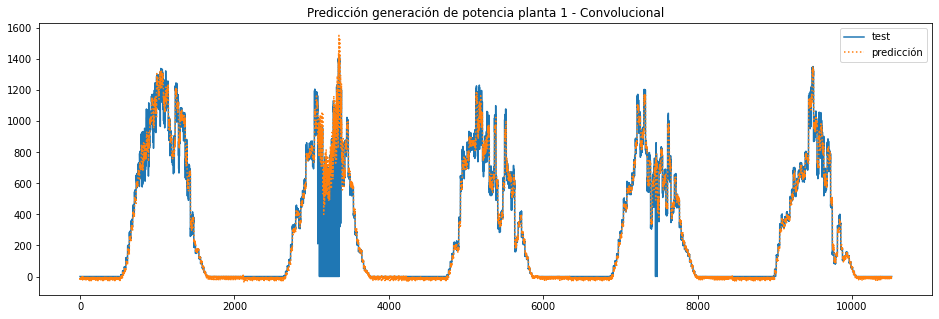

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(np.array(test_set)[:,0],label='test')
plt.plot(conv_predictedCONV[:,0],label="predicción", linestyle = ':')
plt.legend(loc='best')
plt.title("Predicción generación de potencia planta 1 - Convolucional")
plt.show()

In [ ]:
print(return_rmse(np.array(test_set)[:,0],conv_predictedCONV[:,0]))

The root mean squared error is 54.405351719281306.
None
